In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image

In [10]:
# Define dataset paths
original_path = "First Print"
counterfeit_path = "Second Print"

# Define image transformations (normalize, resize, convert to tensor)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [22]:
# Custom PyTorch Dataset
class QRDataset(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.label = label
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, file) for file in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, self.label

# Load datasets
original_dataset = QRDataset(original_path, label=0, transform=transform)
counterfeit_dataset = QRDataset(counterfeit_path, label=1, transform=transform)

# Combine datasets
dataset = torch.utils.data.ConcatDataset([original_dataset, counterfeit_dataset])

# Split dataset into train & test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
# Define CNN model
class QRClassifier(nn.Module):
    def __init__(self):
        super(QRClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QRClassifier().to(device)

In [24]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/20: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 1/20, Loss: 4.4916


Epoch 2/20: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch 2/20, Loss: 0.7655


Epoch 3/20: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 3/20, Loss: 0.6918


Epoch 4/20: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 4/20, Loss: 0.6614


Epoch 5/20: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 5/20, Loss: 0.6303


Epoch 6/20: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 6/20, Loss: 0.5224


Epoch 7/20: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 7/20, Loss: 0.5072


Epoch 8/20: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 8/20, Loss: 0.4601


Epoch 9/20: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 9/20, Loss: 0.4162


Epoch 10/20: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 10/20, Loss: 0.4067


Epoch 11/20: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 11/20, Loss: 0.3532


Epoch 12/20: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 12/20, Loss: 0.3228


Epoch 13/20: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 13/20, Loss: 0.3101


Epoch 14/20: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 14/20, Loss: 0.3085


Epoch 15/20: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 15/20, Loss: 0.2861


Epoch 16/20: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 16/20, Loss: 0.2393


Epoch 17/20: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 17/20, Loss: 0.1724


Epoch 18/20: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 18/20, Loss: 0.1450


Epoch 19/20: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch 19/20, Loss: 0.1103


Epoch 20/20: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

Epoch 20/20, Loss: 0.1099


Test Accuracy: 0.9500
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.89      1.00      0.94        17

    accuracy                           0.95        40
   macro avg       0.95      0.96      0.95        40
weighted avg       0.96      0.95      0.95        40



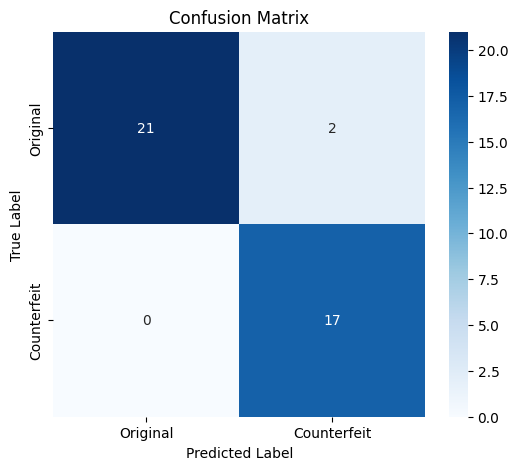

In [26]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Counterfeit'], yticklabels=['Original', 'Counterfeit'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()